In [2]:
import pandas as pd
import re
import numpy as np
from unidecode import unidecode

import matplotlib.pyplot as plt
import seaborn as sns
import collections
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Gui\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Data

In [3]:
df = pd.read_json('dataset/Sarcasm_Headlines_Dataset_v2.json', lines = True)

In [4]:
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [5]:
df.shape

(28619, 3)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [7]:
df.isna().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [8]:
df.drop('article_link', axis = 1, inplace = True)

In [9]:
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


# Data Cleanning

In [10]:
# Variavel para substituir todos os caracteres que não são letras ou espaços em branco
regex = re.compile('[^a-z\s]')
# Transforma o texto em minusculo
df['text'] = df['headline'].str.lower()
# Remove todos os caracteres que não são letras ou espaços 
df['text'] = df['text'].apply(lambda x: regex.sub('', x))
# Remove os acentos
df['text'] = df['text'].apply(lambda x: regex.sub('', unidecode(x)))
# Remove rt and http
df['text'] = df['text'].str.replace('rt|http', '', regex = True)
# Remove palavras com menos de 3 caracteres
df['text'] = df['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

# Removing Stopwords

In [11]:
# Tokenization
df['text'] = df['text'].apply(word_tokenize)

# Removing stopwords
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: [word for word in x if word not in stop_words])

# Word Normalization

In [12]:
# Word normalization
stemmer = SnowballStemmer('english')
df['text'] = df['text'].apply(lambda x: [stemmer.stem(word) for word in x])

# Joining the words back into a single text
df['final_text'] = df['text'].apply(lambda x: ' '.join(x))

# Top 10 most used words

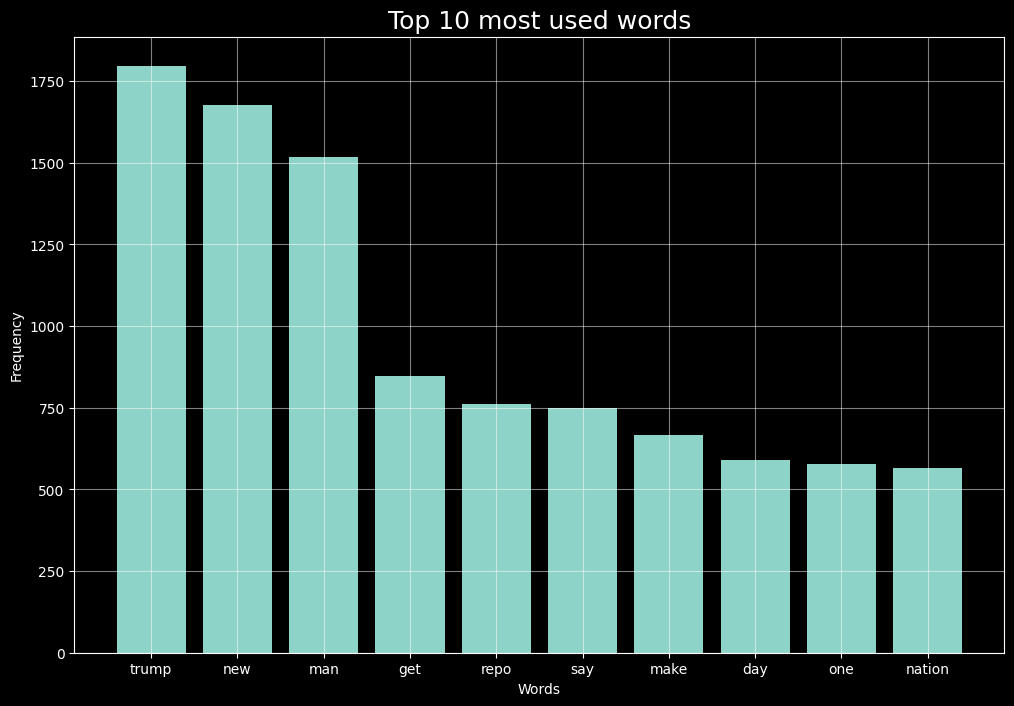

In [28]:
words = []
for text in df['final_text']:
    words.extend(text.split())
word_count = collections.Counter(words)
top_words = dict(word_count.most_common(10))

# Dark Background
plt.style.use('dark_background')
plt.figure(figsize = (12, 8))

# Create the Barplot
plt.bar(range(len(top_words)), list(top_words.values()), align='center')

plt.xticks(range(len(top_words)), list(top_words.keys()))
# Grid Opacity
plt.grid(alpha = 0.5)
# Title
plt.title('Top 10 most used words', fontsize = 18)
# Labels
plt.xlabel('Words')
plt.ylabel('Frequency')

plt.show()

# Word Graph

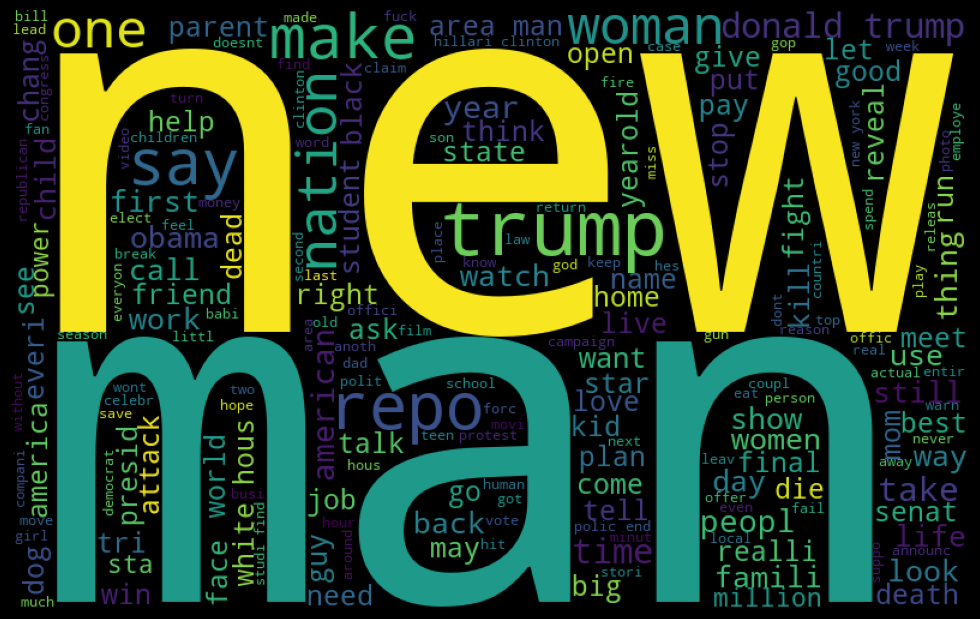

In [26]:
text = ' '.join(caption for caption in df['final_text'])

wordcloud = WordCloud(width = 800, height = 500, background_color = 'black', 
                min_font_size = 10).generate(text)

plt.figure(figsize = (10, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off') 
plt.tight_layout(pad = 0) 
plt.show()

# Split Train/Test and Convert Text to Numerical

In [15]:
X = np.array(df['final_text'])
y = np.array(df['is_sarcastic'])

# Convert text to numerical
cv = CountVectorizer()
X = cv.fit_transform(X)

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.10, random_state = 0)

# Traininig

In [16]:
# Model
bnb = BernoulliNB()

bnb.fit(xtrain, ytrain)

BernoulliNB()

## Predictions

In [17]:
# Predicting
pred_bnb = bnb.predict(xtest)

In [32]:
print(f'Bernoulli Accuracy: {accuracy_score(ytest, pred_bnb)*100:.2f}%')
print('-' * 55)
print(classification_report(ytest, pred_bnb))

Bernoulli Accuracy: 81.31%
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.85      0.83      1493
           1       0.83      0.77      0.80      1369

    accuracy                           0.81      2862
   macro avg       0.81      0.81      0.81      2862
weighted avg       0.81      0.81      0.81      2862



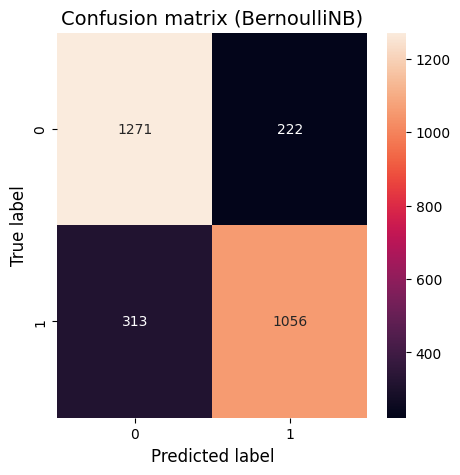

In [30]:
# Make predictions on test data
predictions = bnb.predict(xtest)
predicted_classes = np.where(predictions > 0.5, 1, 0)
true_labels = np.squeeze(ytest)

# Convert true labels to binary values
true_labels = np.where(true_labels > 0.5, 1, 0)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Plot confusion matrix
plt.style.use('default')
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix (BernoulliNB)", fontsize=14)
plt.ylabel('True label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.savefig('BErnoulliNB_confusion_matrix.png')
plt.show()